In [1]:
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('..')))

In [2]:
import yaml
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from stochastic_predictors.modules.experiment.metrics import *
from stochastic_predictors.modules.experiment.attacks import *
from stochastic_predictors.modules.model.cnn import StochasticCNN

In [4]:
experiment_n = "02"

In [5]:
# dev = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
# print("Using device:", dev)
dev = torch.device("cpu")

# load experiment configuration file
with open("../experiments/exp-b04/config-b04.yaml") as config:
    params = dict(yaml.load(config, Loader=yaml.FullLoader))

# load model
net = StochasticCNN(params["model"], params["n_for_features"], params["batch_norm"])
net.load_state_dict(torch.load("../experiments/exp-b06/baseline-adversarial-checkpoint3.pt"))
net = net.cpu()

100%|██████████| 18/18 [00:00<00:00, 4256.98it/s]


In [6]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [7]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [8]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
    layer = model.layers[layer_num]
  
  #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
        weight_tensor = model.layers[layer_num].weight.data
    
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)

        else:
            plot_filters_multi_channel(weight_tensor[:, :3])
#             if weight_tensor.shape[1] == 3:
#                 plot_filters_multi_channel(weight_tensor)
#             else:
#                 print("Can only plot weights with three channels with single channel = False")

    else:
        print("Can only visualize layers which are convolutional")

In [10]:
plot_weights(net, 6, single_channel = False)

Can only visualize layers which are convolutional


In [11]:
net.layers

[StochasticConv2d(1, 6, kernel_size=(3, 3), stride=(1, 1)),
 ReLU(),
 StochasticConv2d(6, 12, kernel_size=(3, 3), stride=(1, 1)),
 ReLU(),
 StochasticConv2d(12, 12, kernel_size=(2, 2), stride=(2, 2)),
 StochasticConv2d(12, 24, kernel_size=(3, 3), stride=(1, 1)),
 ReLU(),
 StochasticConv2d(24, 48, kernel_size=(3, 3), stride=(1, 1)),
 ReLU(),
 StochasticConv2d(48, 48, kernel_size=(2, 2), stride=(2, 2)),
 StochasticConv2d(48, 96, kernel_size=(3, 3), stride=(1, 1)),
 ReLU(),
 StochasticConv2d(96, 96, kernel_size=(2, 2), stride=(2, 2)),
 StochasticConv2d(96, 50, kernel_size=(1, 1), stride=(1, 1)),
 ReLU(),
 StochasticConv2d(50, 10, kernel_size=(1, 1), stride=(1, 1)),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1)]

In [12]:
weight_tensor.min(), weight_tensor.max()

NameError: name 'weight_tensor' is not defined

In [ ]:
weight_tensor.mean(), weight_tensor.std()

In [ ]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

In [6]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


test_set = FashionMNIST("../data", train=False, transform=transforms.ToTensor())
train_loader = DataLoader(test_set, batch_size=1)

In [7]:
input_batch, _ = test_set[5]
input_batch = input_batch.unsqueeze(0)

In [11]:
net.eval()

StochasticCNN(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(12, 12, kernel_size=(2, 2), stride=(2, 2))
  (7): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): Conv2d(48, 48, kernel_size=(2, 2), stride=(2, 2))
  (15): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (17

In [8]:
net.cpu()

StochasticCNN(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(12, 12, kernel_size=(2, 2), stride=(2, 2))
  (7): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): Conv2d(48, 48, kernel_size=(2, 2), stride=(2, 2))
  (15): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (17

In [9]:
input_batch, _ = test_set[5]
input_batch = input_batch.unsqueeze(0)

<Figure size 640x480 with 0 Axes>

<Figure size 1600x200 with 0 Axes>

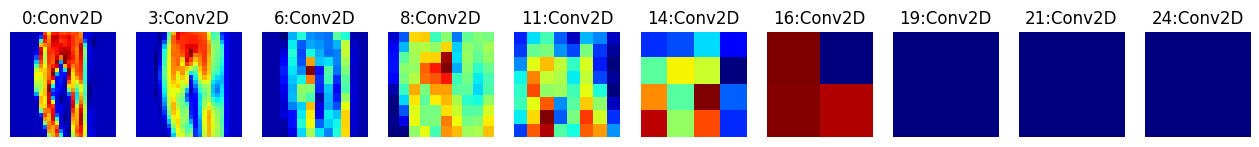

In [12]:
x = input_batch

plt.clf()
fig, axs = plt.subplots(1, 10, figsize=(16, 2))

j = 0
for (i, l) in enumerate(net.layers):
    x = l.forward(x)
    if "Conv2d" in l.__class__.__name__:
        f = (x.detach() ** 2).sum(dim=1).sqrt()[0]
        
#         print(f)
        axs.flat[j].imshow(f.cpu().numpy(), cmap='jet')
        axs.flat[j].set_axis_off()
        axs.flat[j].set_title("{}:{}".format(i, "Conv2D"))
        j += 1
    
plt.show()

In [13]:
input_batch, _ = test_set[0]
input_batch = input_batch.unsqueeze(0)

<Figure size 640x480 with 0 Axes>

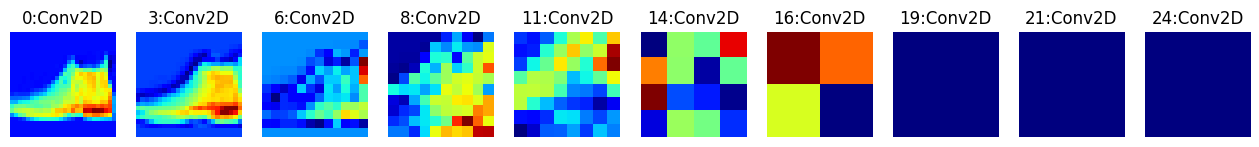

In [14]:
x = input_batch

plt.clf()
fig, axs = plt.subplots(1, 10, figsize=(16, 2))

j = 0
for (i, l) in enumerate(net.layers):
    x = l.forward(x)
    if "Conv2d" in l.__class__.__name__:
        f = (x.detach() ** 2).sum(dim=1).sqrt()[0]
        
#         print(f)
        axs.flat[j].imshow(f.cpu().numpy(), cmap='jet')
        axs.flat[j].set_axis_off()
        axs.flat[j].set_title("{}:{}".format(i, "Conv2D"))
        j += 1
    
plt.show()

In [15]:
y = softmax(net.forward(input_batch))
p = torch.argmax(y, dim=1)
print(CLASSES[p], y[:, p].item())

NameError: name 'softmax' is not defined

In [16]:
input_batch, _ = test_set[58]
input_batch = input_batch.unsqueeze(0)

In [17]:
softmax = nn.Softmax(dim=1)

<Figure size 640x480 with 0 Axes>

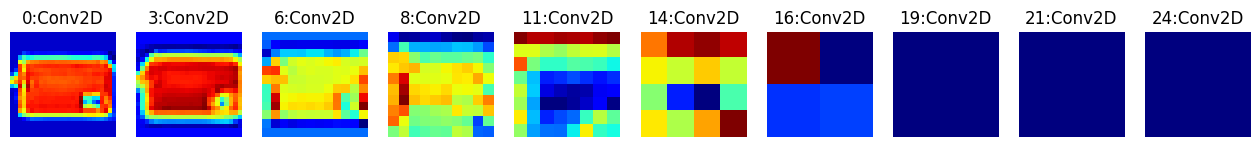

In [18]:
x = input_batch

plt.clf()
fig, axs = plt.subplots(1, 10, figsize=(16, 2))

j = 0
for (i, l) in enumerate(net.layers):
    x = l.forward(x)
    if "Conv2d" in l.__class__.__name__:
        f = (x.detach() ** 2).sum(dim=1).sqrt()[0]

        axs.flat[j].imshow(f.cpu().numpy(), cmap='jet')
        axs.flat[j].set_axis_off()
        axs.flat[j].set_title("{}:{}".format(i, "Conv2D"))
        j += 1
    
plt.show()

In [91]:
y = softmax(net.forward(input_batch))
p = torch.argmax(y, dim=1)
print(CLASSES[p], y[:, p].item())

Pullover 0.9698032736778259


In [92]:
CLASSES = [
    'T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

In [ ]:
for i, (data, target) in enumerate(train_loader):
    print(i, CLASSES[target])

In [ ]:
import torch.nn as nn

In [ ]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

for i in range(8):
    img = test_set[i][0]
    axs.flat[i].imshow(img.permute(1, 2, 0), cmap="gray")
    axs.flat[i].set_axis_off()
plt.show()

In [ ]:
d = nn.Dropout(p=0.1)

In [ ]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

for i in range(8):
    img = test_set[i][0]
    img = d(img)
    axs.flat[i].imshow(img.permute(1, 2, 0), cmap="gray")
    axs.flat[i].set_axis_off()
plt.show()

In [ ]:
d = nn.Dropout(p=0.5)

In [ ]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

for i in range(8):
    img = test_set[i][0]
    img = d(img)
    axs.flat[i].imshow(img.permute(1, 2, 0), cmap="gray")
    axs.flat[i].set_axis_off()
plt.show()

In [22]:
from sklearn.manifold import TSNE

In [93]:
test_loader = DataLoader(test_set, batch_size=5000)

for i, (data, t_target) in enumerate(test_loader):
    data = data.to(dev)
    features = net.features(data)
    
features = features.cpu().detach().numpy()

tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

In [94]:
CLASSES = [
    "T-shirt/top", "Trousers", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

<Figure size 640x480 with 0 Axes>

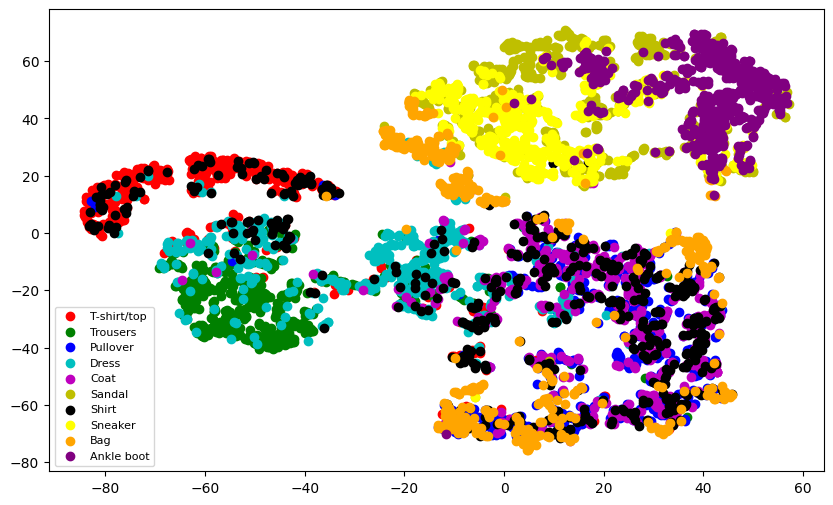

In [103]:
plt.clf()

plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'yellow', 'orange', 'purple']

for i in range(10):
    idx = np.where(t_target == i)[0]
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], color=colors[i], label=CLASSES[i])

# plt.xlabel("x [units]")
# plt.ylabel("y [units]")
# plt.title("tSNE plot of features extracted by model")
# plt.xticks([])
# plt.yticks([])
plt.legend(prop={'size': 8})

plt.show()

In [96]:
from sklearn.metrics import confusion_matrix

In [97]:
for i, (data, target) in enumerate(test_loader):
    data = data.to(dev)
    y = net.forward(data)
    preds = torch.argmax(y, dim=1)

In [98]:
cm = confusion_matrix(t_target, preds)

<Figure size 640x480 with 0 Axes>

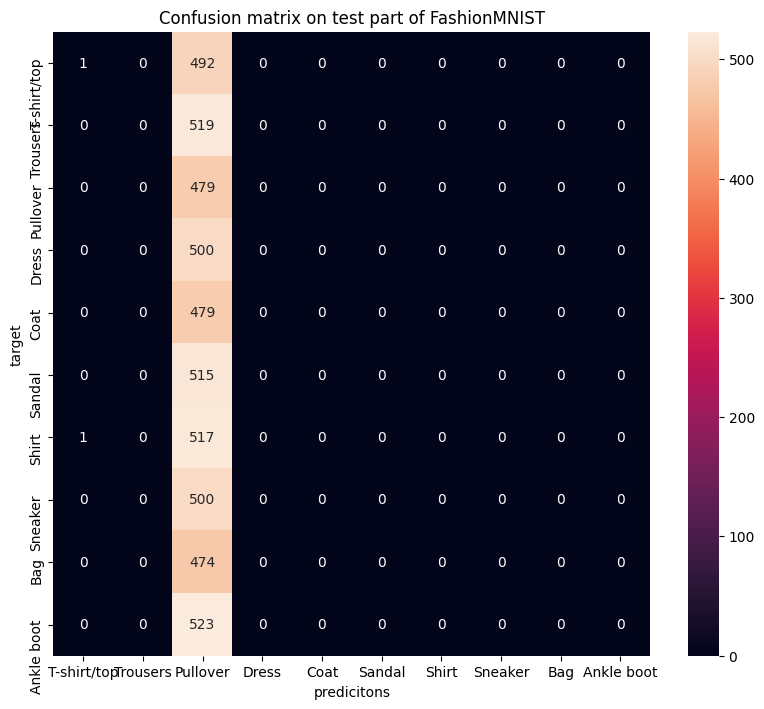

In [99]:
plt.clf()
plt.figure(figsize=(8, 7))

ax = sns.heatmap(cm, annot=True, fmt="g")

ax.set_title("Confusion matrix on test part of FashionMNIST")
ax.figure.tight_layout()
ax.set_xlabel("predicitons")
ax.set_ylabel("target")
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)

plt.show()